In [1]:
# If you're on Colab, set Runtime -> Change runtime type -> GPU (T4, A100, etc.)
!nvidia-smi



Wed Oct  8 14:59:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip -q install --upgrade pip
!pip -q install opencv-python pillow matplotlib albumentations tqdm einops

# (Colab ships with torch/torchvision; uncomment if you need a specific CUDA build)
# !pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121

# Clone official MODNet
%cd /content
!git clone https://github.com/ZHKKKe/MODNet.git
%cd MODNet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.0 MB/s eta 0:00:00
/content
Cloning into 'MODNet'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 276 (delta 24), reused 19 (delta 19), pack-reused 233 (from 1)
Receiving objects: 100% (276/276), 60.77 MiB | 41.10 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/MODNet


In [3]:
import os, sys, glob, math, random, time
from pathlib import Path
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [4]:
import os, sys, types, importlib.util

# --- 0) Locate repo layout ---
CANDIDATES = [
    "/content/MODNet/src",            # typical after: git clone && cd MODNet
    "/content/src",                   # if you moved only src/
]
ROOT = next((p for p in CANDIDATES if os.path.isdir(p)), None)
assert ROOT, "Couldn't find MODNet/src. Make sure you've cloned the repo to /content/MODNet."

MODELS_DIR = os.path.join(ROOT, "models")
MODNET_PY  = os.path.join(MODELS_DIR, "modnet.py")
assert os.path.isfile(MODNET_PY), f"modnet.py not found at {MODNET_PY}"


In [ ]:
!mkdir -p /content/MODNet/pretrained
!wget -q https://github.com/ZHKKKe/MODNet/releases/download/v1/modnet_webcam_portrait_matting.ckpt \
    -O /content/MODNet/pretrained/modnet_webcam_portrait_matting.ckpt


In [6]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import os

# CHANGE THIS to your folder in Drive
DATA_ROOT = Path('/content/drive/MyDrive/modnet_data')

# Define all subdirectories
TRAIN_IMG_DIR = DATA_ROOT/'train/images'
TRAIN_MAT_DIR = DATA_ROOT/'train/mattes'
VAL_IMG_DIR   = DATA_ROOT/'val/images'
VAL_MAT_DIR   = DATA_ROOT/'val/mattes'
TEST_IMG_DIR  = DATA_ROOT/'test/images'
BG_DIR        = DATA_ROOT/'bgs'           # optional backgrounds

# Function to create dirs if not exist
def ensure_dir(path):
    if not path.exists():
        print(f"No folder {path}, creating...")
        path.mkdir(parents=True, exist_ok=True)
        print("✔ New directory created.")
    else:
        print(f"{path} exists, do nothing.")

# Ensure all needed directories
for d in [TRAIN_IMG_DIR, TRAIN_MAT_DIR, VAL_IMG_DIR, VAL_MAT_DIR, TEST_IMG_DIR, BG_DIR]:
    ensure_dir(d)



Mounted at /content/drive
No folder /content/drive/MyDrive/modnet_data/train/images, creating...
✔ New directory created.
No folder /content/drive/MyDrive/modnet_data/train/mattes, creating...
✔ New directory created.
No folder /content/drive/MyDrive/modnet_data/val/images, creating...
✔ New directory created.
No folder /content/drive/MyDrive/modnet_data/val/mattes, creating...
✔ New directory created.
No folder /content/drive/MyDrive/modnet_data/test/images, creating...
✔ New directory created.
No folder /content/drive/MyDrive/modnet_data/bgs, creating...
✔ New directory created.


In [19]:
from pathlib import Path

AIM_ROOT = Path('/content/drive/MyDrive/AIM')
print("📂 AIM folders:", [p.name for p in AIM_ROOT.iterdir() if p.is_dir()])

print("\n🖼 original/")
for p in list((AIM_ROOT/'original').glob('*'))[:10]:
    print(" ", p.name)

print("\n🧍 usr/")
for p in list((AIM_ROOT/'usr').glob('*'))[:10]:
    print(" ", p.name)

print("\n🎭 mask/")
for p in list((AIM_ROOT/'mask').glob('*'))[:10]:
    print(" ", p.name)


📂 AIM folders: ['mask', 'trimap', 'original', 'usr']

🖼 original/
  o_5e83cbbe.jpg
  o_67f36f9b.jpg
  o_5e7d1db9.jpg
  o_659c5db8.jpg
  o_61e47e14.jpg
  o_6372e660.jpg
  o_5d53cc84.jpg
  o_5a15b5f2.jpg
  o_610852d2.jpg
  o_69a1b2bd.jpg

🧍 usr/
  o_57102043.png
  o_52a2115b.png
  o_5851551d.png
  o_5219d2ba.png
  o_57684f7c.png
  o_54308893.png
  o_561c2a05.png
  o_53100c73.png
  o_52aadf1d.png
  o_5031923f.png

🎭 mask/
  o_2b9227eb.png
  o_2972dbc2.png
  o_2749e288.png
  o_247d445d.png
  o_1ea2b894.png
  o_122b2e34.png
  o_0bcaa573.png
  o_34d216ed.png
  o_542332e9.png
  o_fabaf6e3.png


In [20]:
import os, shutil, random
from pathlib import Path

# --- Set paths ---
AIM_ROOT = Path('/content/drive/MyDrive/AIM')
DATA_ROOT = Path('/content/drive/MyDrive/modnet_data')

SRC_IMG = AIM_ROOT / 'usr'     # use usr images as foreground input
SRC_MASK = AIM_ROOT / 'mask'   # use mask as ground truth alpha matte

TRAIN_IMG_DIR = DATA_ROOT/'train/images'
TRAIN_MAT_DIR = DATA_ROOT/'train/mattes'
VAL_IMG_DIR   = DATA_ROOT/'val/images'
VAL_MAT_DIR   = DATA_ROOT/'val/mattes'
TEST_IMG_DIR  = DATA_ROOT/'test/images'

for d in [TRAIN_IMG_DIR, TRAIN_MAT_DIR, VAL_IMG_DIR, VAL_MAT_DIR, TEST_IMG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# --- Collect files ---
images = sorted([p for p in SRC_IMG.glob('*') if p.suffix.lower() in ['.jpg', '.jpeg', '.png']])
mattes = sorted([p for p in SRC_MASK.glob('*') if p.suffix.lower() in ['.jpg', '.jpeg', '.png']])

n = min(len(images), len(mattes))
pairs = list(zip(images[:n], mattes[:n]))
print(f"📦 Found {n} pairs (usr↔mask by order).")

# --- Split 80/10/10 ---
random.shuffle(pairs)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
train_pairs = pairs[:n_train]
val_pairs   = pairs[n_train:n_train+n_val]
test_pairs  = pairs[n_train+n_val:]

# --- Copy ---
def copy_pairs(pairs, dst_img, dst_mat):
    for img, mat in pairs:
        shutil.copy2(img, dst_img / img.name)
        shutil.copy2(mat, dst_mat / mat.name)

copy_pairs(train_pairs, TRAIN_IMG_DIR, TRAIN_MAT_DIR)
copy_pairs(val_pairs, VAL_IMG_DIR, VAL_MAT_DIR)

# test images only
for img, _ in test_pairs:
    shutil.copy2(img, TEST_IMG_DIR / img.name)

print(f"✅ Done! Train: {len(train_pairs)}, Val: {len(val_pairs)}, Test: {len(test_pairs)}")
print(f"Data ready in: {DATA_ROOT}")



📦 Found 500 pairs (usr↔mask by order).
✅ Done! Train: 400, Val: 50, Test: 50
Data ready in: /content/drive/MyDrive/modnet_data


In [21]:
IMG_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}

def list_pairs(img_dir, mat_dir):
    images = []
    for p in sorted(glob.glob(str(img_dir/'*'))):
        if Path(p).suffix.lower() in IMG_EXT:
            name = Path(p).stem
            # matte assumed .png (can change if needed)
            m = mat_dir/f"{name}.png"
            if m.exists():
                images.append((Path(p), m))
    return images

class MattingDataset(Dataset):
    def __init__(self, img_dir, mat_dir, image_size=512, is_train=True):
        self.pairs = list_pairs(img_dir, mat_dir)
        self.is_train = is_train
        self.image_size = image_size

        aug_list = []
        if is_train:
            aug_list += [
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10, p=0.5),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.5),
            ]

        self.transform = A.Compose(
            aug_list + [
                A.LongestMaxSize(max_size=image_size),
                A.PadIfNeeded(min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
                A.Normalize(),
                ToTensorV2()
            ],
            additional_targets={'alpha':'mask','trimap':'mask'}
        )

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mat_path = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        alpha = cv2.imread(str(mat_path), cv2.IMREAD_UNCHANGED)
        if alpha.ndim == 3:
            alpha = alpha[..., -1]  # use A channel if RGBA matte
        alpha = alpha.astype(np.float32)
        if alpha.max() > 1.0:
            alpha = alpha / 255.0
        alpha = np.clip(alpha, 0.0, 1.0)

        trimap = alpha_to_trimap(alpha)

        transformed = self.transform(
            image=img,
            alpha=(alpha*255).astype(np.uint8),
            trimap=trimap
        )

        image = transformed['image']                  # (3,H,W) float
        alpha_t = transformed['alpha'].float()/255.0  # (H,W) float 0~1
        trimap_t = transformed['trimap'].float()/255.0  # (H,W) 0,0.5,1

        return {
            'image': image,
            'alpha': alpha_t.unsqueeze(0),   # (1,H,W)
            'trimap': trimap_t.unsqueeze(0), # (1,H,W)
            'name': img_path.stem
        }

train_ds = MattingDataset(TRAIN_IMG_DIR, TRAIN_MAT_DIR, image_size=512, is_train=True)
val_ds   = MattingDataset(VAL_IMG_DIR,   VAL_MAT_DIR,   image_size=512, is_train=False)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds)


/tmp/ipython-input-684487246.py:31: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),


(400, 50)

In [24]:
import os, sys, importlib.util, types

# Path where you cloned the repo
repo_root = "/content/MODNet"
modnet_file = os.path.join(repo_root, "src", "models", "modnet.py")
backbones_file = os.path.join(repo_root, "src", "models", "backbones", "__init__.py")

# Create stub packages so relative imports in modnet.py work
pkg_src = types.ModuleType("src"); pkg_src.__path__ = [os.path.join(repo_root, "src")]
pkg_models = types.ModuleType("src.models"); pkg_models.__path__ = [os.path.join(repo_root, "src", "models")]
sys.modules["src"] = pkg_src
sys.modules["src.models"] = pkg_models

# Load backbones first
spec_bk = importlib.util.spec_from_file_location("src.models.backbones", backbones_file)
bk_mod = importlib.util.module_from_spec(spec_bk)
sys.modules["src.models.backbones"] = bk_mod
spec_bk.loader.exec_module(bk_mod)

# Load modnet
spec_md = importlib.util.spec_from_file_location("src.models.modnet", modnet_file)
modnet_mod = importlib.util.module_from_spec(spec_md)
sys.modules["src.models.modnet"] = modnet_mod
spec_md.loader.exec_module(modnet_mod)

# Get class
MODNet = modnet_mod.MODNet
print("✅ MODNet class loaded:", MODNet)


✅ MODNet class loaded: <class 'src.models.modnet.MODNet'>


In [27]:
# MODNet has 3-branch architecture; repo provides the model class.
# We'll train to predict alpha. (You could also include semantic/detail branches losses—this keeps it simpler.)

model = MODNet(backbone_pretrained=False)  # MobileNetV2 backbone
model = model.to(device)

# Freeze backbone for first warmup (optional, helps stability with small datasets)
for name, p in model.backbone.named_parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# After a few epochs we can unfreeze:
UNFREEZE_EPOCH = 3

def matting_loss(pred_alpha, gt_alpha):
    """
    Simple combination of L1 and Laplacian-like gradient loss.
    pred_alpha, gt_alpha: (N,1,H,W)
    """
    l1 = F.l1_loss(pred_alpha, gt_alpha)
    def grad(img):
        gx = img[:,:,:,1:] - img[:,:,:,:-1]
        gy = img[:,:,1:,:] - img[:,:,:-1,:]
        return gx, gy
    gx_p, gy_p = grad(pred_alpha)
    gx_g, gy_g = grad(gt_alpha)
    grad_l1 = F.l1_loss(gx_p, gx_g) + F.l1_loss(gy_p, gy_g)
    return l1 + 0.5*grad_l1


In [29]:
import cv2
import numpy as np

def alpha_to_trimap(alpha, ksize=(7,7), erode_iter=5, dilate_iter=5):
    """
    Convert alpha matte (0–1) to trimap:
    0 = background, 128 = uncertain, 255 = foreground
    """
    if alpha.max() <= 1.0:
        alpha = (alpha * 255).astype(np.uint8)
    else:
        alpha = alpha.astype(np.uint8)

    fg = (alpha == 255).astype(np.uint8) * 255
    bg = (alpha == 0).astype(np.uint8) * 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    fg_erode = cv2.erode(fg, kernel, iterations=erode_iter)
    bg_dilate = cv2.erode(bg, kernel, iterations=dilate_iter)  # erode bg = dilate unknown

    trimap = np.full_like(alpha, 128, dtype=np.uint8)
    trimap[bg_dilate == 255] = 0
    trimap[fg_erode == 255] = 255

    return trimap


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

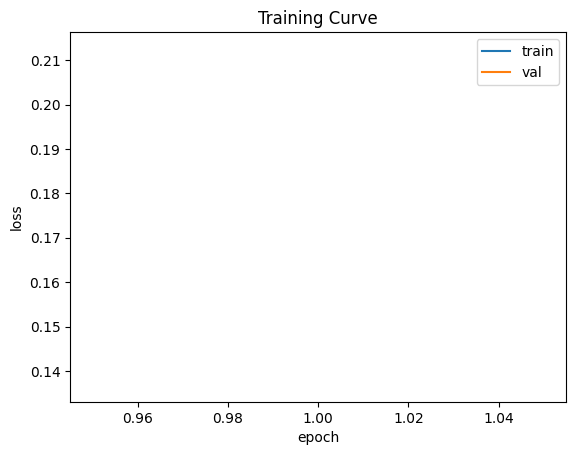

✅ Saved best checkpoint @ epoch 1, val=0.1368 → /content/drive/MyDrive/modnet_runs/modnet_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

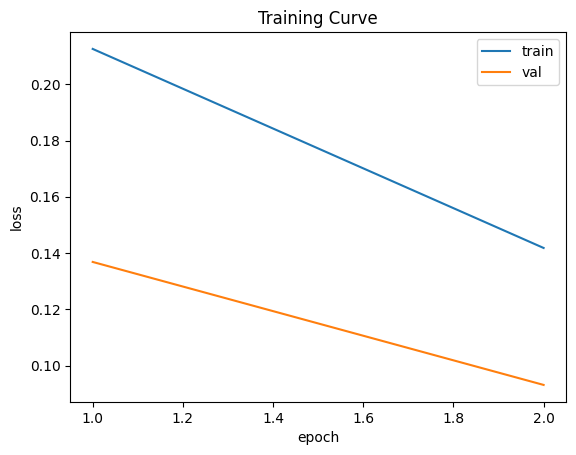

✅ Saved best checkpoint @ epoch 2, val=0.0931 → /content/drive/MyDrive/modnet_runs/modnet_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e1ca319cb80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7e1ca319cb80>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^^
 ^ ^

  0%|          | 0/13 [00:00<?, ?it/s]

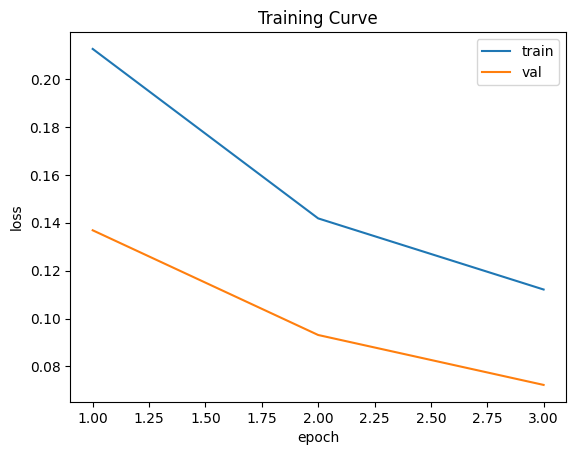

✅ Saved best checkpoint @ epoch 3, val=0.0723 → /content/drive/MyDrive/modnet_runs/modnet_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

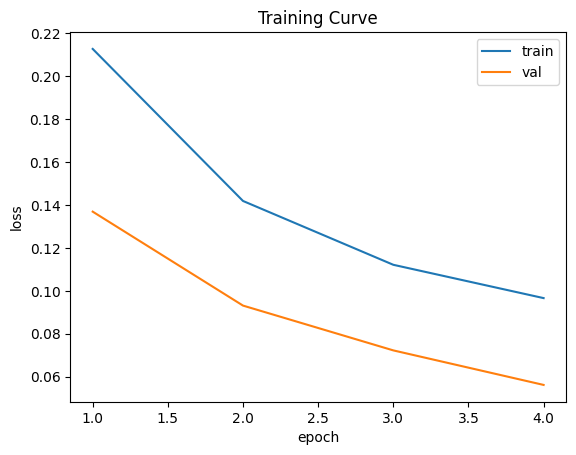

✅ Saved best checkpoint @ epoch 4, val=0.0562 → /content/drive/MyDrive/modnet_runs/modnet_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

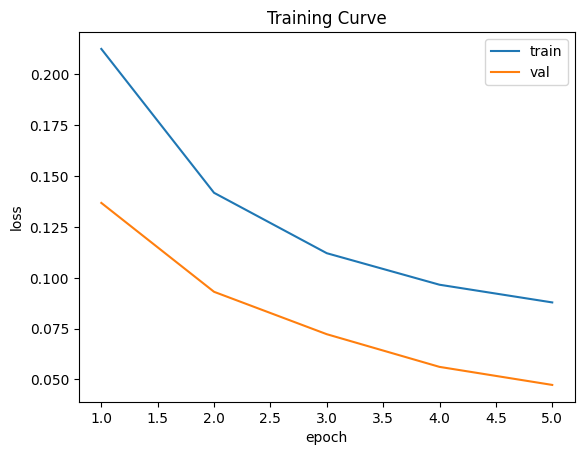

✅ Saved best checkpoint @ epoch 5, val=0.0473 → /content/drive/MyDrive/modnet_runs/modnet_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

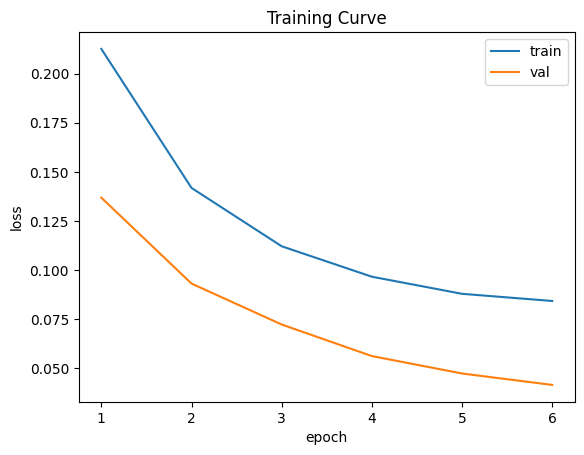

✅ Saved best checkpoint @ epoch 6, val=0.0415 → /content/drive/MyDrive/modnet_runs/modnet_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e1ca319cb80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


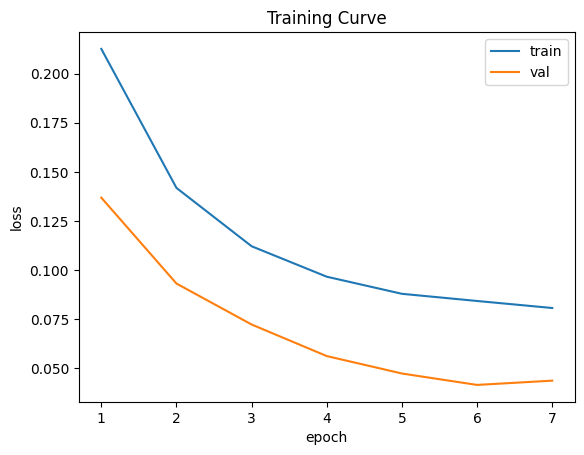

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

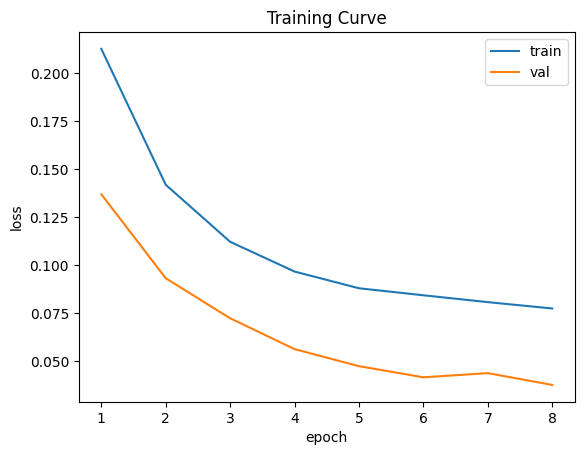

✅ Saved best checkpoint @ epoch 8, val=0.0376 → /content/drive/MyDrive/modnet_runs/modnet_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

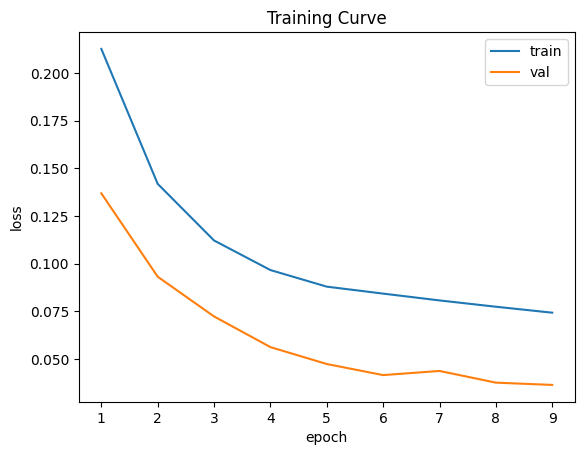

✅ Saved best checkpoint @ epoch 9, val=0.0364 → /content/drive/MyDrive/modnet_runs/modnet_best.pth


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

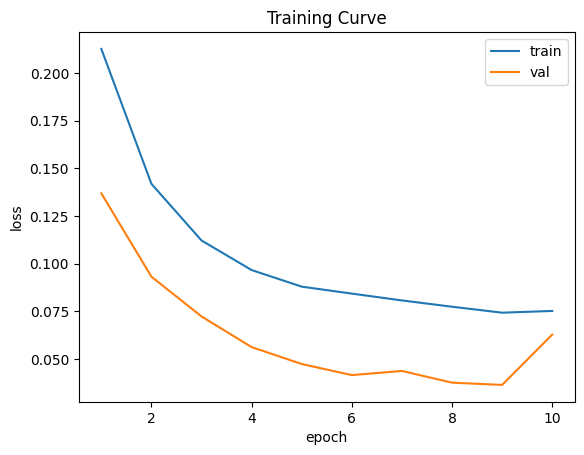

In [30]:
def run_epoch(loader, training=True):
    if training:
        model.train()
    else:
        model.eval()

    epoch_loss = 0.0
    n = 0
    pbar = tqdm(loader)
    for batch in pbar:
        image = batch['image'].to(device)
        alpha = batch['alpha'].to(device)  # (N,1,H,W)

        if training:
            optimizer.zero_grad()

        # MODNet forward returns semantic, detail, matte
        with torch.set_grad_enabled(training):
            pred_sem, pred_detail, pred_matte = model(image, True)  # train_mode=True to get 3 outputs
            # Use pred_matte (N,1,H,W) for loss; you can add aux losses if you like.
            loss = matting_loss(pred_matte, alpha)

            if training:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

        epoch_loss += loss.item()*image.size(0)
        n += image.size(0)
        pbar.set_description(f"{'Train' if training else 'Val'} loss: {loss.item():.4f}")

    return epoch_loss / max(n,1)

EPOCHS = 10
train_hist, val_hist = [], []
best_val = float('inf')
save_dir = Path('/content/drive/MyDrive/modnet_runs')
save_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = save_dir/'modnet_best.pth'

for epoch in range(1, EPOCHS+1):
    if epoch == UNFREEZE_EPOCH:
        for p in model.backbone.parameters():
            p.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

    tl = run_epoch(train_loader, training=True)
    vl = run_epoch(val_loader, training=False)

    train_hist.append(tl); val_hist.append(vl)

    # Plot (updates each epoch)
    plt.figure()
    plt.plot(range(1,len(train_hist)+1), train_hist, label='train')
    plt.plot(range(1,len(val_hist)+1), val_hist, label='val')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Training Curve'); plt.legend()
    plt.show()

    if vl < best_val:
        best_val = vl
        torch.save({'epoch': epoch,
                    'model_state': model.state_dict(),
                    'opt_state': optimizer.state_dict(),
                    'val_loss': vl}, ckpt_path)
        print(f"✅ Saved best checkpoint @ epoch {epoch}, val={vl:.4f} → {ckpt_path}")


In [31]:
@torch.no_grad()
def infer_alpha(model, img_bgr, image_size=512):
    model.eval()
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    tfm = A.Compose([
        A.LongestMaxSize(max_size=image_size),
        A.PadIfNeeded(min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
        A.Normalize()
    ])
    transformed = tfm(image=img_rgb)
    x = transformed['image']
    x = torch.from_numpy(x.transpose(2,0,1)).float().unsqueeze(0)/255.0
    x = x.to(device)

    # inference mode returns only matte if train_flag=False
    pred_matte = model(x, False)  # (N,1,H,W)
    matte = pred_matte[0,0].cpu().numpy()

    # Resize back to original
    matte = cv2.resize(matte, (w,h), interpolation=cv2.INTER_CUBIC)
    matte = np.clip(matte, 0.0, 1.0)
    return matte

def composite(fg_bgr, alpha, bg_bgr):
    h, w = fg_bgr.shape[:2]
    bg = cv2.resize(bg_bgr, (w,h), interpolation=cv2.INTER_AREA)
    a = alpha[..., None]
    comp = a*fg_bgr.astype(np.float32) + (1-a)*bg.astype(np.float32)
    return np.clip(comp,0,255).astype(np.uint8)


In [33]:
import cv2, torch, numpy as np, glob
import matplotlib.pyplot as plt
from pathlib import Path
import albumentations as A

@torch.no_grad()
def infer_alpha(model, img_bgr, device, image_size=512):
    """
    Run MODNet inference on one BGR image and return the predicted alpha matte (H,W) float32 0~1
    """
    model.eval()
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    tfm = A.Compose([
        A.LongestMaxSize(max_size=image_size),
        A.PadIfNeeded(min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize()
    ])
    transformed = tfm(image=img_rgb)
    x = transformed['image']
    x = torch.from_numpy(x.transpose(2, 0, 1)).float().unsqueeze(0) / 255.0
    x = x.to(device)

    # --- Inference call ---
    try:
        output = model(x, inference=True)  # newer MODNet versions
    except TypeError:
        output = model(x, False)           # older MODNet versions

    # --- Handle tuple or tensor ---
    if isinstance(output, (tuple, list)):
        matte = output[-1]
    else:
        matte = output

    matte = matte[0, 0].cpu().numpy()
    matte = cv2.resize(matte, (w, h), interpolation=cv2.INTER_CUBIC)
    return np.clip(matte, 0.0, 1.0)


def composite(fg_bgr, alpha, bg_bgr):
    """
    Blend foreground and background using alpha matte
    """
    h, w = fg_bgr.shape[:2]
    bg = cv2.resize(bg_bgr, (w, h), interpolation=cv2.INTER_AREA)
    a = alpha[..., None]
    comp = a * fg_bgr.astype(np.float32) + (1 - a) * bg.astype(np.float32)
    return np.clip(comp, 0, 255).astype(np.uint8)

✅ Loaded checkpoint from epoch 9 (val_loss=0.0364)
⚠️ No background found. Will only save alpha mattes.


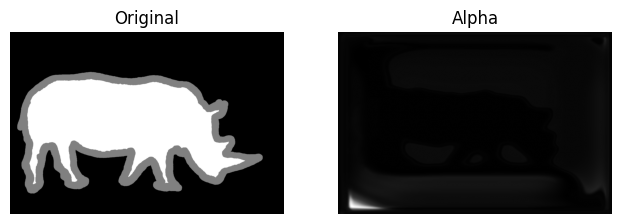

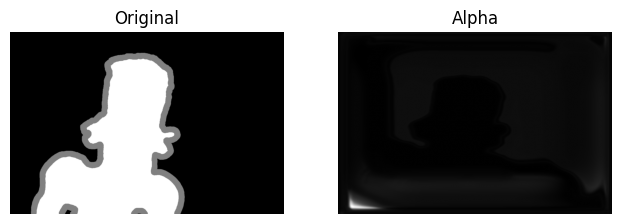

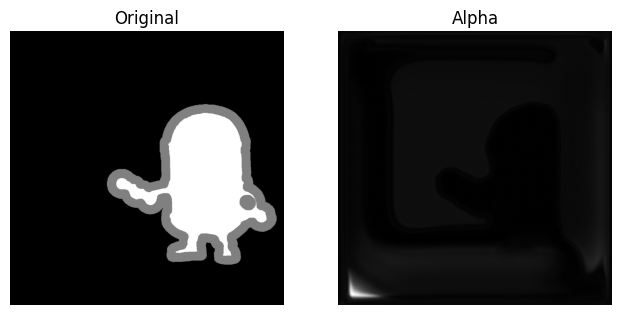

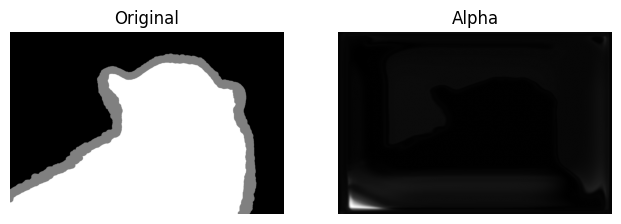

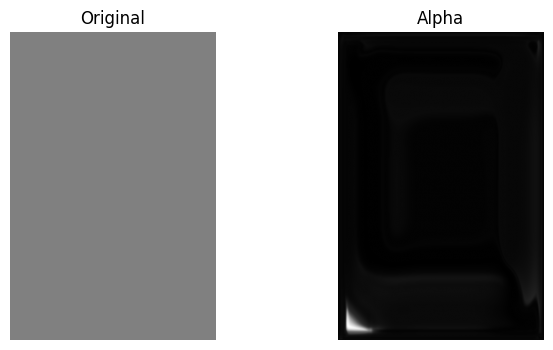

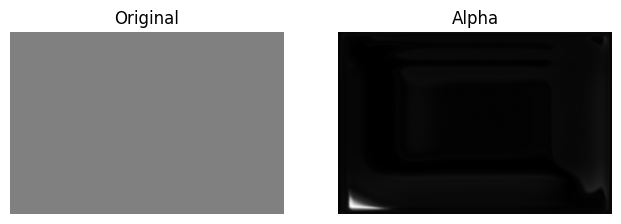

✅ All outputs saved to: /content/drive/MyDrive/modnet_runs/predictions


In [35]:
# --- Load best checkpoint ---
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.eval()
print(f"✅ Loaded checkpoint from epoch {ckpt['epoch']} (val_loss={ckpt['val_loss']:.4f})")

# --- Load a background image (optional) ---
bg_paths = sorted([p for p in glob.glob(str(BG_DIR/'*')) if Path(p).suffix.lower() in IMG_EXT]) if BG_DIR.exists() else []
bg_img = None
if bg_paths:
    bg_img = cv2.imread(bg_paths[0])
    print(f"🖼 Using background: {bg_paths[0]}")
else:
    print("⚠️ No background found. Will only save alpha mattes.")

# --- Inference on test images ---
test_paths = sorted([p for p in glob.glob(str(TEST_IMG_DIR/'*')) if Path(p).suffix.lower() in IMG_EXT])[:6]
out_dir = save_dir/'predictions'
out_dir.mkdir(parents=True, exist_ok=True)

for p in test_paths:
    bgr = cv2.imread(p)
    alpha = infer_alpha(model, bgr, device, image_size=512)

    # Save alpha matte
    alpha_png = (alpha * 255).astype(np.uint8)
    cv2.imwrite(str(out_dir / (Path(p).stem + '_alpha.png')), alpha_png)

    # Composite with background if available
    if bg_img is not None:
        comp = composite(bgr, alpha, bg_img)
        cv2.imwrite(str(out_dir / (Path(p).stem + '_comp.png')), comp)

    # Show preview
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Original'); plt.axis('off')
    plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title('Alpha'); plt.axis('off')
    plt.imshow(alpha, cmap='gray')

    if bg_img is not None:
        plt.subplot(1, 3, 3)
        plt.title('Composite'); plt.axis('off')
        plt.imshow(cv2.cvtColor(comp, cv2.COLOR_BGR2RGB))

    plt.show()

print(f"✅ All outputs saved to: {out_dir}")


In [36]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_sad, total_mse, n = 0.0, 0.0, 0
    for batch in tqdm(loader, desc='Eval'):
        img = batch['image'].to(device)
        gt = batch['alpha'].to(device)  # (N,1,H,W)
        pred_sem, pred_detail, pred_matte = model(img, True)
        pred = torch.clamp(pred_matte, 0, 1)
        sad = torch.sum(torch.abs(pred-gt), dim=(1,2,3))  # per-sample
        mse = torch.mean((pred-gt)**2, dim=(1,2,3))
        total_sad += sad.sum().item()
        total_mse += mse.sum().item()
        n += img.size(0)
    return total_sad/n, total_mse/n

val_sad, val_mse = evaluate(val_loader)
print(f"Validation: SAD={val_sad:.4f}, MSE={val_mse:.6f}")


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

Validation: SAD=7964.8510, MSE=0.018203


In [38]:
# Example of enabling AMP + cosine schedule for longer runs
scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

LONG_EPOCHS = 0  # set >0 if you want to continue training

for e in range(LONG_EPOCHS):
    model.train()
    epoch_loss = 0; n=0
    for batch in tqdm(train_loader, desc=f"FT Epoch {e+1}/{LONG_EPOCHS}"):
        image = batch['image'].to(device)
        alpha = batch['alpha'].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device=='cuda')):
            pred_sem, pred_detail, pred_matte = model(image, True)
            loss = matting_loss(pred_matte, alpha)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        epoch_loss += loss.item()*image.size(0)
        n += image.size(0)
    print("FT epoch loss:", epoch_loss/max(n,1))


/tmp/ipython-input-3364101511.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))
